In [1]:
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob
import numpy as np
from skimage.feature import hog
% matplotlib inline

In [2]:
cars = glob.glob('vehicles/*/*.png')
notcars = glob.glob('non-vehicles/*/*.png')

In [3]:
def data_look(car_list,notcar_list):
    data_dict = {}
    data_dict["n_cars"] = len(car_list)
    data_dict["n_notcars"] = len(notcar_list)
    image = cv2.imread(notcar_list[0])
    data_dict["image_shape"] = image.shape
    data_dict["data_type"] = image.dtype
    return data_dict

In [4]:
data_dict = data_look(cars,notcars)
print(data_dict)

{'n_cars': 8792, 'n_notcars': 8968, 'image_shape': (64, 64, 3), 'data_type': dtype('uint8')}


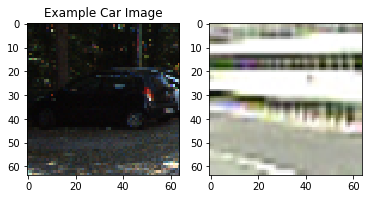

In [5]:
# choose two random indices
car_ind = np.random.randint(0,data_dict["n_cars"])
notcar_ind = np.random.randint(0,data_dict["n_notcars"])
# read the images
car_image = cv2.imread(cars[car_ind])
notcar_image = cv2.imread(notcars[notcar_ind])
car_image = cv2.cvtColor(car_image,cv2.COLOR_BGR2RGB)
notcar_image = cv2.cvtColor(notcar_image,cv2.COLOR_BGR2RGB)
# plot the image
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)

In [6]:
def get_hog_features(img,orient,pix_per_cell,cell_per_block,vis=True,feature_vec=True):
    if vis:
        features,hog_image = hog(img, orientations=orient,pixels_per_cell=(pix_per_cell,pix_per_cell)\
            ,cells_per_block=(cell_per_block,cell_per_block),visualise=vis,feature_vector=feature_vec,block_norm="L2-Hys")
        return features,hog_image
    else:
        features = hog(img,orientations=orient,pixels_per_cell=(pix_per_cell,pix_per_cell), \
                      cells_per_block=(cell_per_block,cell_per_block),visualise=vis,feature_vector=feature_vec,block_norm="L2-Hys")
        return features

In [7]:
def color_hist(img,nbins=32,bin_range=(0,256)):
    channel_1_hist = np.histogram(img[:,:,0],bins=32,range=bin_range)
    channel_2_hist = np.histogram(img[:,:,1],bins=32,range=bin_range)
    channel_3_hist = np.histogram(img[:,:,2],bins=32,range=bin_range)
    hist_feature = np.concatenate([channel_1_hist[0],channel_2_hist[0],channel_3_hist[0]])
    
    return hist_feature

In [8]:
def spatial_feature(img,size=(32,32)):
    # return a one dimensional feature vector
    features = cv2.resize(img,size).ravel()
   
    return features

In [9]:
# hog_channel can take values of 0, 1, 2, or "ALL"
# meaning that you extract HOG features from the first, second, third, or all color channels respectively.
def extract_features(imgs,cspace,spatial_size,nbins,bin_range,orient,pix_per_cell,cell_per_block,hog_channel,\
                     spatial_feat=True,hist_feat=True,hog_feat=True):
    
    feature_list = []
    for filename in imgs:
        features = []
        image = cv2.imread(filename)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
       
        # Apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                image = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
            if cspace == 'YCrCb':
                image = cv2.cvtColor(image,cv2.COLOR_RGB2YCrCb)
            if cspace == 'YUV':
                image = cv2.cvtColor(image,cv2.COLOR_RGB2YUV)
       
        # Compute spatial features if flag is set
        if spatial_feat == True:
            feature = spatial_feature(image,spatial_size)
            features.append(feature)
        
        # Compute histogram features if flag is set
        if hist_feat == True:
            feature = color_hist(image,nbins,bin_range).astype(np.float64)
            features.append(feature)
          
        
        # Compute HOG features if flag is set
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(image.shape[2]):
                    feature = get_hog_features(image[:,:,channel],orient,pix_per_cell,cell_per_block,vis=False)
                    hog_features.append(feature)
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(image[:,:,hog_channel],orient,pix_per_cell,cell_per_block,vis=False)
            features.append(hog_features)
        
        feature_list.append(np.concatenate(features))
        
    return feature_list

In [10]:
cspace = 'YUV'
spatial_size = (32,32)
nbins = 32
bin_range = (0,256)
orient = 13
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL'

In [11]:
car_features = extract_features(cars, cspace, spatial_size, nbins, bin_range, orient\
             , pix_per_cell, cell_per_block, hog_channel)

In [12]:
notcar_features = extract_features(notcars,cspace, spatial_size, nbins, bin_range, orient\
             , pix_per_cell, cell_per_block, hog_channel)

In [13]:
X = np.vstack((car_features,notcar_features)).astype(np.float64)

In [14]:
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

In [15]:
from sklearn.preprocessing import StandardScaler

In [21]:
scaler = StandardScaler()

scaler.fit(X)

# data = (data - mean) / np.sqrt(var)
scaled_X = scaler.transform(X)

In [22]:
# Split data into randomized training and test sets
from sklearn.model_selection import train_test_split
rand_state = np.random.randint(0, 100)
X_train,X_test,y_train,y_test = train_test_split(scaled_X,y,test_size=0.2,random_state=rand_state)

In [23]:
from sklearn.svm import LinearSVC
# Use a linear SVC 
svc = LinearSVC()

In [24]:
svc.fit(X_train,y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [25]:
svc.score(X_test, y_test)

0.99155405405405406

In [26]:
from sklearn.externals import joblib

In [27]:
joblib.dump(svc, 'classifier.pkl') 

['classifier.pkl']

### check the score of the SVC

In [28]:
svc = joblib.load('classifier.pkl') 

In [29]:
print('SVC predicts: ', svc.predict(X_test[0:10]))
print('For these 10 labels:', y_test[0:10])

SVC predicts:  [ 1.  1.  0.  1.  1.  0.  1.  0.  1.  1.]
For these 10 labels: [ 1.  1.  0.  1.  1.  0.  1.  0.  1.  1.]


In [30]:
# take an image (not file name) as input
def single_img_features(img,cspace='RGB',spatial_size=(32,32),nbins=32,bin_range=(0,256),orient=9,\
        pix_per_cell=8, cell_per_block=2,hog_channel=0,spatial_feat=True,hist_feat=True,hog_feat=True):
    # Define an empty list to receive features
    features = []
    # Apply color conversion if other than 'RGB'
   
    if cspace != 'RGB':
        if cspace == 'HSV':
            cvt_img = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
        
        if cspace == 'YCrCb':
            cvt_img = cv2.cvtColor(img,cv2.COLOR_RGB2YCrCb)
        
    else:
        cvt_img = img.copy()
   
    # Compute spatial features if flag is set
    if spatial_feat == True:
        feature = spatial_feature(cvt_img,spatial_size).astype(np.float64)
        #print(feature.shape)
        features.append(feature)
        
    # Compute histogram features if flag is set
    if hist_feat == True:
        feature = color_hist(cvt_img,nbins,bin_range).astype(np.float64)
        #print(feature.shape)
        features.append(feature)
    

    # Compute HOG features if flag is set
    if hog_feat == True:
        
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(cvt_img.shape[2]):
                feature = get_hog_features(img[:,:,channel],orient,pix_per_cell,cell_per_block,vis=False,feature_vec=False)
                feature = feature.ravel()
                #print(feature.shape)
                hog_features.append(feature)
                
                
            hog_features = np.ravel(hog_features)
            
        
        else:
            hog_features = get_hog_features(img[:,:,hog_channel],orient,pix_per_cell,cell_per_block,vis=False)
     
        features.append(hog_features)
        
    return np.concatenate(features)

In [31]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.7, 0.7)):
    window_list = []
    
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    
    nx_pix_per_step = xy_window[0] * (1 - xy_overlap[0])
    ny_pix_per_step = xy_window[1] * (1 - xy_overlap[1])
    
    nx_window = np.int32((x_start_stop[1] - x_start_stop[0]) / nx_pix_per_step)
    ny_window = np.int32((y_start_stop[1] - y_start_stop[0]) / ny_pix_per_step)
    
    
    for i in range(nx_window-1):
        for j in range(ny_window-1):
            offset_x = i * nx_pix_per_step + x_start_stop[0]
            offset_y = j * ny_pix_per_step + y_start_stop[0]
            top_left = (np.int32(offset_x),np.int32(offset_y))
            bottom_right = (np.int32(offset_x + xy_window[0]), np.int32(offset_y + xy_window[1]))
            window_list.append((top_left,bottom_right))
    return window_list
    

In [32]:
def search_windows(img,windows,svc):
    hot = []
   
    for window in windows:
        #print(img[window[0][1]:window[1][1],window[0][0]:window[1][0]].shape)
        test_img = cv2.resize(img[window[0][1]:window[1][1],window[0][0]:window[1][0]],(64,64))
       
       
        feature = single_img_features(test_img,cspace='HSV',spatial_size=(32,32),nbins=32,bin_range=(0,256),orient=9,\
            pix_per_cell=8, cell_per_block=2,hog_channel='ALL',spatial_feat=True,hist_feat=True,hog_feat=True)
        
       
        # Scale extracted features to be fed to classifier
        feature = feature.reshape(1,-1)
        
        scaled_feature = scaler.transform(feature)
        
        prediction = svc.predict(scaled_feature)
      
        if prediction == 1:
            hot.append(window)

    return hot

In [28]:
def draw_boxes(image,bboxes,color=(0,0,255),thickness=6):
    img_copy = image.copy()
    for bbox in bboxes:
        cv2.rectangle(img_copy,bbox[0],bbox[1],color,thickness)
    return img_copy

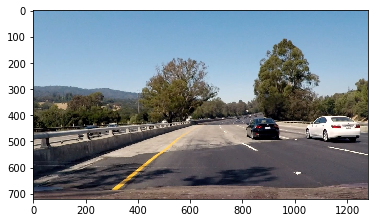

In [29]:
image = cv2.imread('test_images/test4.jpg')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [30]:
windows = slide_window(image,x_start_stop=[None,None],y_start_stop=[350,720],xy_window=(64,64),xy_overlap=(0.5,0.5))

In [31]:
hot_windows  = search_windows(image,windows,svc)

ValueError: operands could not be broadcast together with shapes (1,8460) (9636,) (1,8460) 

In [ ]:
window_img = draw_boxes(image, hot_windows, color=(0, 0, 255), thickness=6)  

In [32]:
plt.imshow(window_img)

NameError: name 'window_img' is not defined

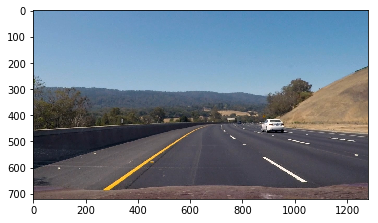

In [61]:
image = cv2.imread('test_images/test3.jpg')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [62]:
def convert_color(img,conv):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img,cv2.COLOR_RGB2YUV)

In [733]:
def find_cars(img,scale,orient,pix_per_cell,cell_per_block,svc,cells_per_step,ystart,ystop,xstart,xstop):
    
    bbox_list = []
    
    draw_img = img.copy()
    window = 64
    features = []

    img_tosearch = img[ystart:ystop,xstart:xstop,:]
    img_tosearch = convert_color(img_tosearch, conv='RGB2YUV')
    if scale != 1:
        img_tosearch = cv2.resize(img_tosearch,(np.int(img_tosearch.shape[1]/scale), np.int(img_tosearch.shape[0]/scale)))
        
    ch1 = img_tosearch[:,:,0]
    ch2 = img_tosearch[:,:,1]
    ch3 = img_tosearch[:,:,2]
    
    nx_blocks = (img_tosearch.shape[1] // pix_per_cell) - cell_per_block + 1
    ny_blocks = (img_tosearch.shape[0] // pix_per_cell) - cell_per_block + 1
    
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    
    nx_steps = (nx_blocks - nblocks_per_window) // cells_per_step + 1
    ny_steps = (ny_blocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1,orient,pix_per_cell,cell_per_block,vis=False,feature_vec=False)
    hog2 = get_hog_features(ch2,orient,pix_per_cell,cell_per_block,vis=False,feature_vec=False)
    hog3 = get_hog_features(ch3,orient,pix_per_cell,cell_per_block,vis=False,feature_vec=False)
   
  
    for x in range(nx_steps):
        for y in range(ny_steps):
           
            features = []
            ypos = y * cells_per_step
            xpos = x * cells_per_step
        
            
            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell
            
            # Extract the image patch
            subimg = img_tosearch[ytop:ytop+window,xleft:xleft+window]
           
            # Get features
            feature = spatial_feature(subimg,spatial_size).astype(np.float64)
            features.append(feature)
        
            hist_features = color_hist(subimg,nbins,bin_range).astype(np.float64)
            features.append(hist_features)
            
            # Extract HOG for this patch
            hog1_feature = hog1[ypos:ypos+nblocks_per_window,xpos:xpos+nblocks_per_window].ravel()
            hog2_feature = hog2[ypos:ypos+nblocks_per_window,xpos:xpos+nblocks_per_window].ravel()
            hog3_feature = hog3[ypos:ypos+nblocks_per_window,xpos:xpos+nblocks_per_window].ravel()
           
           
            features.append(hog1_feature)
            features.append(hog2_feature)
            features.append(hog3_feature)
    
            features = np.hstack(features).reshape(1,-1)
            # Scale features
            scaled_feature = scaler.transform(features)
            predict = svc.predict(scaled_feature)
            
            
            if predict:
                score = svc.decision_function(scaled_feature)
                #print(score)
                
                xleft_draw = np.int(xleft * scale)
                ytop_draw = np.int(ytop * scale)
                window_draw = np.int(window * scale)
                left_top = (xleft_draw+xstart, ytop_draw+ystart)
                right_bottom = (xleft_draw+window_draw+xstart,ytop_draw+window_draw+ystart)
                bbox_list.append((left_top,right_bottom))
                cv2.rectangle(draw_img,(xleft_draw+xstart, ytop_draw+ystart),(xleft_draw+window_draw+xstart,ytop_draw+window_draw+ystart)\
                    ,(0,0,255),6) 
   
    return draw_img,bbox_list

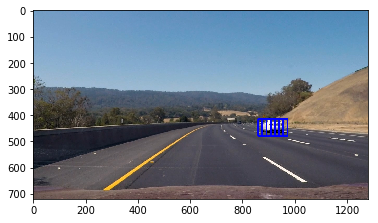

In [808]:
image = cv2.imread('test_images/test3.jpg')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
scale = 1
draw_img,box_list = find_cars(image,scale,13,16,2,svc,1,350,478,300,1280)
cv2.line(draw_img,(400,0),(400,720),color=(0,255,0),thickness=1)
plt.imshow(draw_img)

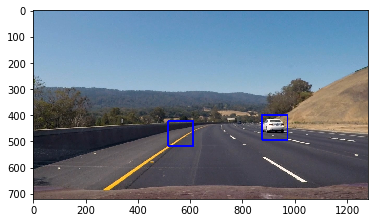

In [818]:
image = cv2.imread('test_images/test3.jpg')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
scale = 1.5
draw_img,box_list = find_cars(image,scale,13,16,2,svc,1,350,542,300,1280)
plt.imshow(draw_img)

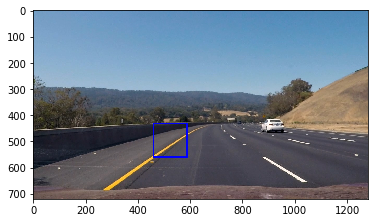

In [819]:
image = cv2.imread('test_images/test3.jpg')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
scale = 2
draw_img,box_list = find_cars(image,scale,13,16,2,svc,1,400,656,300,1280)
plt.imshow(draw_img)

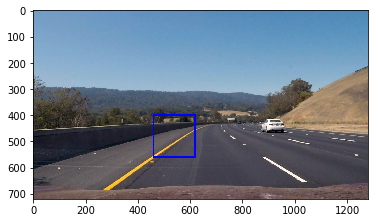

In [820]:
image = cv2.imread('test_images/test3.jpg')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
scale = 2.5
draw_img,box_list = find_cars(image,scale,13,16,2,svc,1,400,720,300,1280)
plt.imshow(draw_img)

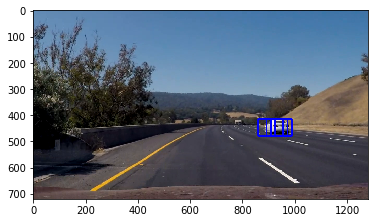

In [874]:
image = cv2.imread('test_images/test10.jpg')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
bbox_list = []
scales = [1,1.5,2,2.5]
draw_img,box_list = find_cars(image,scales[0],13,16,2,svc,1,350,478,300,1280)
plt.imshow(draw_img)
bbox_list.extend(box_list)
draw_img,box_list = find_cars(image,scales[1],13,16,2,svc,1,350,542,300,1280)
bbox_list.extend(box_list)
draw_img,box_list = find_cars(image,scales[2],13,16,2,svc,1,400,656,300,1280)
bbox_list.extend(box_list)
draw_img,box_list = find_cars(image,scales[3],13,16,2,svc,1,400,720,300,1280)
bbox_list.extend(box_list)
#cv2.line(draw_img, (0,520), (1280,520), (0,255,0), thickness=5)
#plt.imshow(draw_img)

In [875]:
def add_heat(heatmap,bbox_list):
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1],box[0][0]:box[1][0]] += 1
        
    return heatmap

In [876]:
def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

In [877]:
def draw_labeled_bboxes(img, labeled_array,num_features):
    # Iterate through all detected cars
    for car_number in range(1,num_features+1):
        nonzero = np.nonzero(labeled_array==car_number)
        nonzero_x = nonzero[1]
        nonzero_y = nonzero[0]
        # Define a bounding box based on min/max x and y
        top_left = (np.min(nonzero_x),np.min(nonzero_y))
        bottom_right = (np.max(nonzero_x),np.max(nonzero_y))
        #if (np.max(nonzero_x) - np.min(nonzero_x) >= 64) and (np.max(nonzero_y) - np.min(nonzero_y) >= 64):
        cv2.rectangle(img, top_left, bottom_right, (0,0,255), 6)
    return img

In [878]:
from scipy.ndimage.measurements import label

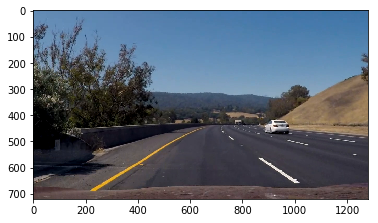

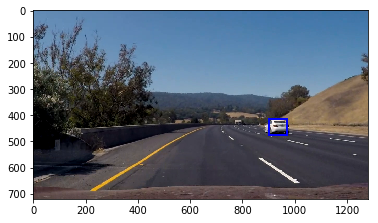

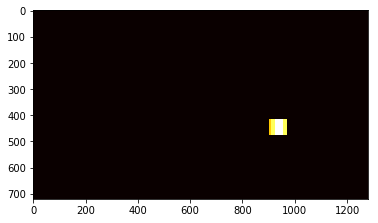

In [879]:
plt.imshow(image)
heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
heatmap = add_heat(heatmap,bbox_list)
heatmap = apply_threshold(heatmap,3)
labeled_array, num_features = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labeled_array, num_features)
plt.figure()
plt.imshow(draw_img)
plt.figure()
plt.imshow(heatmap, cmap='hot')

In [882]:
def process_image(image):
    #mpimg.imsave("test11.jpg",image)
    bbox_list = []
    scales = [1,1.5,2,2.5]
    draw_img,box_list = find_cars(image,scales[0],13,16,2,svc,1,350,478,300,1280)
    bbox_list.extend(box_list)
    draw_img,box_list = find_cars(image,scales[1],13,16,2,svc,1,350,542,300,1280)
    bbox_list.extend(box_list)
    draw_img,box_list = find_cars(image,scales[2],13,16,2,svc,1,400,656,300,1280)
    bbox_list.extend(box_list)
    draw_img,box_list = find_cars(image,scales[3],13,16,2,svc,1,400,720,300,1280)
    heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
    heatmap = add_heat(heatmap,bbox_list)
    heatmap = apply_threshold(heatmap,3)
    labeled_array, num_features = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labeled_array, num_features)
    return draw_img

In [883]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
output = 'output6.mp4'
#heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
clip1 = VideoFileClip("project_video.mp4")
new_clip = clip1.fl_image(process_image)
new_clip.write_videofile(output,audio=False)

[MoviePy] >>>> Building video output6.mp4
[MoviePy] Writing video output6.mp4







  0%|          | 0/1261 [00:00<?, ?it/s]




  0%|          | 1/1261 [00:00<20:43,  1.01it/s]




  0%|          | 2/1261 [00:01<20:38,  1.02it/s]




  0%|          | 3/1261 [00:03<21:37,  1.03s/it]




  0%|          | 4/1261 [00:04<20:57,  1.00s/it]




  0%|          | 5/1261 [00:05<20:56,  1.00s/it]




  0%|          | 6/1261 [00:06<21:16,  1.02s/it]




  1%|          | 7/1261 [00:07<21:54,  1.05s/it]




  1%|          | 8/1261 [00:08<22:29,  1.08s/it]




  1%|          | 9/1261 [00:09<22:34,  1.08s/it]




  1%|          | 10/1261 [00:10<21:45,  1.04s/it]




  1%|          | 11/1261 [00:11<21:17,  1.02s/it]




  1%|          | 12/1261 [00:12<20:48,  1.00it/s]




  1%|          | 13/1261 [00:13<20:25,  1.02it/s]




  1%|          | 14/1261 [00:14<20:00,  1.04it/s]




  1%|          | 15/1261 [00:15<19:52,  1.05it/s]




  1%|▏         | 16/1261 [00:16<19:50,  1.05it/s]




  1%|▏         | 17/1261 [00:17<19:54,  1.04it/s]




  1%|▏         | 18/1261 [00:17<19:42,  1

  9%|▉         | 118/1261 [01:54<19:20,  1.02s/it]




  9%|▉         | 119/1261 [01:55<18:42,  1.02it/s]




 10%|▉         | 120/1261 [01:56<19:25,  1.02s/it]




 10%|▉         | 121/1261 [01:57<20:18,  1.07s/it]




 10%|▉         | 122/1261 [01:58<21:19,  1.12s/it]




 10%|▉         | 123/1261 [01:59<22:48,  1.20s/it]




 10%|▉         | 124/1261 [02:01<22:25,  1.18s/it]




 10%|▉         | 125/1261 [02:02<24:38,  1.30s/it]




 10%|▉         | 126/1261 [02:04<27:54,  1.48s/it]




 10%|█         | 127/1261 [02:05<25:55,  1.37s/it]




 10%|█         | 128/1261 [02:06<24:32,  1.30s/it]




 10%|█         | 129/1261 [02:08<25:58,  1.38s/it]




 10%|█         | 130/1261 [02:09<26:53,  1.43s/it]




 10%|█         | 131/1261 [02:10<24:38,  1.31s/it]




 10%|█         | 132/1261 [02:11<23:07,  1.23s/it]




 11%|█         | 133/1261 [02:12<21:51,  1.16s/it]




 11%|█         | 134/1261 [02:14<21:38,  1.15s/it]




 11%|█         | 135/1261 [02:16<26:54,  1.43s/it]




 11%|█    

 19%|█▊        | 235/1261 [04:00<16:44,  1.02it/s]




 19%|█▊        | 236/1261 [04:01<16:52,  1.01it/s]




 19%|█▉        | 237/1261 [04:02<16:31,  1.03it/s]




 19%|█▉        | 238/1261 [04:03<16:21,  1.04it/s]




 19%|█▉        | 239/1261 [04:04<16:00,  1.06it/s]




 19%|█▉        | 240/1261 [04:05<16:19,  1.04it/s]




 19%|█▉        | 241/1261 [04:06<16:53,  1.01it/s]




 19%|█▉        | 242/1261 [04:07<18:33,  1.09s/it]




 19%|█▉        | 243/1261 [04:08<18:20,  1.08s/it]




 19%|█▉        | 244/1261 [04:09<18:14,  1.08s/it]




 19%|█▉        | 245/1261 [04:10<17:54,  1.06s/it]




 20%|█▉        | 246/1261 [04:11<17:23,  1.03s/it]




 20%|█▉        | 247/1261 [04:12<17:19,  1.02s/it]




 20%|█▉        | 248/1261 [04:13<17:14,  1.02s/it]




 20%|█▉        | 249/1261 [04:14<17:33,  1.04s/it]




 20%|█▉        | 250/1261 [04:15<17:28,  1.04s/it]




 20%|█▉        | 251/1261 [04:17<18:34,  1.10s/it]




 20%|█▉        | 252/1261 [04:19<23:22,  1.39s/it]




 20%|██   

 28%|██▊       | 352/1261 [05:55<13:34,  1.12it/s]




 28%|██▊       | 353/1261 [05:56<13:23,  1.13it/s]




 28%|██▊       | 354/1261 [05:56<13:22,  1.13it/s]




 28%|██▊       | 355/1261 [05:57<13:25,  1.12it/s]




 28%|██▊       | 356/1261 [05:58<13:12,  1.14it/s]




 28%|██▊       | 357/1261 [05:59<13:09,  1.14it/s]




 28%|██▊       | 358/1261 [06:00<13:15,  1.14it/s]




 28%|██▊       | 359/1261 [06:01<13:12,  1.14it/s]




 29%|██▊       | 360/1261 [06:02<13:09,  1.14it/s]




 29%|██▊       | 361/1261 [06:03<13:12,  1.14it/s]




 29%|██▊       | 362/1261 [06:03<12:55,  1.16it/s]




 29%|██▉       | 363/1261 [06:04<12:47,  1.17it/s]




 29%|██▉       | 364/1261 [06:05<12:42,  1.18it/s]




 29%|██▉       | 365/1261 [06:06<12:45,  1.17it/s]




 29%|██▉       | 366/1261 [06:07<12:37,  1.18it/s]




 29%|██▉       | 367/1261 [06:08<12:41,  1.17it/s]




 29%|██▉       | 368/1261 [06:08<12:34,  1.18it/s]




 29%|██▉       | 369/1261 [06:09<12:40,  1.17it/s]




 29%|██▉  

 37%|███▋      | 469/1261 [07:36<11:32,  1.14it/s]




 37%|███▋      | 470/1261 [07:37<11:19,  1.16it/s]




 37%|███▋      | 471/1261 [07:38<11:17,  1.17it/s]




 37%|███▋      | 472/1261 [07:38<11:08,  1.18it/s]




 38%|███▊      | 473/1261 [07:39<11:09,  1.18it/s]




 38%|███▊      | 474/1261 [07:40<11:09,  1.18it/s]




 38%|███▊      | 475/1261 [07:41<11:11,  1.17it/s]




 38%|███▊      | 476/1261 [07:42<11:11,  1.17it/s]




 38%|███▊      | 477/1261 [07:43<11:11,  1.17it/s]




 38%|███▊      | 478/1261 [07:44<11:07,  1.17it/s]




 38%|███▊      | 479/1261 [07:44<11:04,  1.18it/s]




 38%|███▊      | 480/1261 [07:45<11:10,  1.17it/s]




 38%|███▊      | 481/1261 [07:46<11:21,  1.14it/s]




 38%|███▊      | 482/1261 [07:47<11:19,  1.15it/s]




 38%|███▊      | 483/1261 [07:48<11:22,  1.14it/s]




 38%|███▊      | 484/1261 [07:49<11:23,  1.14it/s]




 38%|███▊      | 485/1261 [07:50<11:25,  1.13it/s]




 39%|███▊      | 486/1261 [07:51<11:31,  1.12it/s]




 39%|███▊ 

 46%|████▋     | 586/1261 [09:17<09:48,  1.15it/s]




 47%|████▋     | 587/1261 [09:18<09:49,  1.14it/s]




 47%|████▋     | 588/1261 [09:19<09:54,  1.13it/s]




 47%|████▋     | 589/1261 [09:20<09:52,  1.13it/s]




 47%|████▋     | 590/1261 [09:21<09:54,  1.13it/s]




 47%|████▋     | 591/1261 [09:22<09:53,  1.13it/s]




 47%|████▋     | 592/1261 [09:23<09:59,  1.12it/s]




 47%|████▋     | 593/1261 [09:24<09:57,  1.12it/s]




 47%|████▋     | 594/1261 [09:24<09:54,  1.12it/s]




 47%|████▋     | 595/1261 [09:25<09:49,  1.13it/s]




 47%|████▋     | 596/1261 [09:26<09:40,  1.15it/s]




 47%|████▋     | 597/1261 [09:27<09:36,  1.15it/s]




 47%|████▋     | 598/1261 [09:28<09:45,  1.13it/s]




 48%|████▊     | 599/1261 [09:29<09:43,  1.13it/s]




 48%|████▊     | 600/1261 [09:30<09:36,  1.15it/s]




 48%|████▊     | 601/1261 [09:30<09:28,  1.16it/s]




 48%|████▊     | 602/1261 [09:31<09:25,  1.17it/s]




 48%|████▊     | 603/1261 [09:32<09:27,  1.16it/s]




 48%|████▊

 56%|█████▌    | 703/1261 [10:58<07:57,  1.17it/s]




 56%|█████▌    | 704/1261 [10:59<07:52,  1.18it/s]




 56%|█████▌    | 705/1261 [11:00<07:56,  1.17it/s]




 56%|█████▌    | 706/1261 [11:01<07:53,  1.17it/s]




 56%|█████▌    | 707/1261 [11:02<07:53,  1.17it/s]




 56%|█████▌    | 708/1261 [11:03<07:59,  1.15it/s]




 56%|█████▌    | 709/1261 [11:03<08:02,  1.14it/s]




 56%|█████▋    | 710/1261 [11:04<08:00,  1.15it/s]




 56%|█████▋    | 711/1261 [11:05<08:05,  1.13it/s]




 56%|█████▋    | 712/1261 [11:06<08:08,  1.12it/s]




 57%|█████▋    | 713/1261 [11:07<08:09,  1.12it/s]




 57%|█████▋    | 714/1261 [11:08<08:06,  1.12it/s]




 57%|█████▋    | 715/1261 [11:09<08:10,  1.11it/s]




 57%|█████▋    | 716/1261 [11:10<08:09,  1.11it/s]




 57%|█████▋    | 717/1261 [11:11<08:05,  1.12it/s]




 57%|█████▋    | 718/1261 [11:11<08:04,  1.12it/s]




 57%|█████▋    | 719/1261 [11:12<07:52,  1.15it/s]




 57%|█████▋    | 720/1261 [11:13<07:58,  1.13it/s]




 57%|█████

 65%|██████▌   | 820/1261 [12:43<06:28,  1.13it/s]




 65%|██████▌   | 821/1261 [12:44<06:24,  1.14it/s]




 65%|██████▌   | 822/1261 [12:45<06:28,  1.13it/s]




 65%|██████▌   | 823/1261 [12:46<06:30,  1.12it/s]




 65%|██████▌   | 824/1261 [12:47<06:25,  1.13it/s]




 65%|██████▌   | 825/1261 [12:48<06:20,  1.15it/s]




 66%|██████▌   | 826/1261 [12:48<06:15,  1.16it/s]




 66%|██████▌   | 827/1261 [12:49<06:13,  1.16it/s]




 66%|██████▌   | 828/1261 [12:50<06:12,  1.16it/s]




 66%|██████▌   | 829/1261 [12:51<06:09,  1.17it/s]




 66%|██████▌   | 830/1261 [12:52<06:13,  1.15it/s]




 66%|██████▌   | 831/1261 [12:53<06:12,  1.15it/s]




 66%|██████▌   | 832/1261 [12:54<06:08,  1.17it/s]




 66%|██████▌   | 833/1261 [12:54<06:02,  1.18it/s]




 66%|██████▌   | 834/1261 [12:55<06:05,  1.17it/s]




 66%|██████▌   | 835/1261 [12:56<06:06,  1.16it/s]




 66%|██████▋   | 836/1261 [12:57<06:05,  1.16it/s]




 66%|██████▋   | 837/1261 [12:58<05:59,  1.18it/s]




 66%|█████

 74%|███████▍  | 937/1261 [14:24<04:37,  1.17it/s]




 74%|███████▍  | 938/1261 [14:25<04:35,  1.17it/s]




 74%|███████▍  | 939/1261 [14:26<04:34,  1.17it/s]




 75%|███████▍  | 940/1261 [14:27<04:32,  1.18it/s]




 75%|███████▍  | 941/1261 [14:28<04:32,  1.18it/s]




 75%|███████▍  | 942/1261 [14:29<04:33,  1.17it/s]




 75%|███████▍  | 943/1261 [14:29<04:35,  1.16it/s]




 75%|███████▍  | 944/1261 [14:30<04:33,  1.16it/s]




 75%|███████▍  | 945/1261 [14:31<04:30,  1.17it/s]




 75%|███████▌  | 946/1261 [14:32<04:28,  1.17it/s]




 75%|███████▌  | 947/1261 [14:33<04:30,  1.16it/s]




 75%|███████▌  | 948/1261 [14:34<04:27,  1.17it/s]




 75%|███████▌  | 949/1261 [14:35<04:25,  1.17it/s]




 75%|███████▌  | 950/1261 [14:35<04:27,  1.16it/s]




 75%|███████▌  | 951/1261 [14:36<04:26,  1.16it/s]




 75%|███████▌  | 952/1261 [14:37<04:26,  1.16it/s]




 76%|███████▌  | 953/1261 [14:38<04:23,  1.17it/s]




 76%|███████▌  | 954/1261 [14:39<04:23,  1.17it/s]




 76%|█████

 84%|████████▎ | 1053/1261 [16:08<02:57,  1.17it/s]




 84%|████████▎ | 1054/1261 [16:09<02:57,  1.17it/s]




 84%|████████▎ | 1055/1261 [16:10<02:57,  1.16it/s]




 84%|████████▎ | 1056/1261 [16:11<02:58,  1.15it/s]




 84%|████████▍ | 1057/1261 [16:12<02:57,  1.15it/s]




 84%|████████▍ | 1058/1261 [16:12<03:00,  1.13it/s]




 84%|████████▍ | 1059/1261 [16:13<03:01,  1.11it/s]




 84%|████████▍ | 1060/1261 [16:14<02:57,  1.13it/s]




 84%|████████▍ | 1061/1261 [16:15<02:53,  1.15it/s]




 84%|████████▍ | 1062/1261 [16:16<02:52,  1.16it/s]




 84%|████████▍ | 1063/1261 [16:17<02:49,  1.17it/s]




 84%|████████▍ | 1064/1261 [16:18<02:49,  1.16it/s]




 84%|████████▍ | 1065/1261 [16:19<02:49,  1.16it/s]




 85%|████████▍ | 1066/1261 [16:19<02:51,  1.14it/s]




 85%|████████▍ | 1067/1261 [16:20<02:51,  1.13it/s]




 85%|████████▍ | 1068/1261 [16:21<02:51,  1.13it/s]




 85%|████████▍ | 1069/1261 [16:22<02:49,  1.13it/s]




 85%|████████▍ | 1070/1261 [16:23<02:48,  1.13it

 93%|█████████▎| 1168/1261 [17:49<01:19,  1.17it/s]




 93%|█████████▎| 1169/1261 [17:50<01:19,  1.16it/s]




 93%|█████████▎| 1170/1261 [17:50<01:18,  1.16it/s]




 93%|█████████▎| 1171/1261 [17:51<01:16,  1.17it/s]




 93%|█████████▎| 1172/1261 [17:52<01:16,  1.17it/s]




 93%|█████████▎| 1173/1261 [17:53<01:16,  1.16it/s]




 93%|█████████▎| 1174/1261 [17:54<01:16,  1.14it/s]




 93%|█████████▎| 1175/1261 [17:55<01:14,  1.16it/s]




 93%|█████████▎| 1176/1261 [17:56<01:12,  1.17it/s]




 93%|█████████▎| 1177/1261 [17:56<01:12,  1.16it/s]




 93%|█████████▎| 1178/1261 [17:57<01:11,  1.16it/s]




 93%|█████████▎| 1179/1261 [17:58<01:10,  1.16it/s]




 94%|█████████▎| 1180/1261 [17:59<01:10,  1.16it/s]




 94%|█████████▎| 1181/1261 [18:00<01:09,  1.15it/s]




 94%|█████████▎| 1182/1261 [18:01<01:08,  1.15it/s]




 94%|█████████▍| 1183/1261 [18:02<01:08,  1.13it/s]




 94%|█████████▍| 1184/1261 [18:03<01:08,  1.12it/s]




 94%|█████████▍| 1185/1261 [18:04<01:07,  1.12it

[MoviePy] Done.
[MoviePy] >>>> Video ready: output6.mp4 

